# **TCGA Comparators**

Comparing performance between BuDDI, MLP, and AdaBoost in predicting the tumor from cfDNA


# **Imports**

In [64]:
# import the VAE code
import sys
from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# general imports

import warnings
import numpy as np
import scanpy as sc
import scipy
import anndata as ad

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# sklearn imports
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier


# programming stuff
import time
import os
import pickle
from pathlib import Path

# tensorflow stuff
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, normalize, plot_model
from sklearn.model_selection import train_test_split


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


In [65]:
## parameters
sc_aug_data_path = f"{os.getcwd()}/../data/pseudobulks/"
res_data_path = f"{os.getcwd()}/../results/buddiM2_tcga/"

cfdna_file = f"{os.getcwd()}/../data/cfDNA/cfdna_processed_all.h5ad"

regions_path = f"{os.getcwd()}/../data/reference/TCGA_regions.csv"


num_genes = 7000

exp_id = "all-tcga"
res_id = "all-tcga"

RETRAIN_MODELS = False


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [67]:


# now get the training data

# read in order
# oritinal samples
sample_order = [5001, 5000, 1000, 500, 100, 19000, 99000, 99900]

X_concat = None
Y_concat = None
meta_concat = None
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_pseudobulk_file(sc_aug_data_path, curr_samp, "STIM", "Train", exp_id)
    pseudobulks_df.columns = gene_df

    if X_concat is None:
        X_concat, Y_concat, meta_concat = pseudobulks_df, prop_df, metadata_df
    else:
        X_concat = pd.concat([X_concat, pseudobulks_df])
        Y_concat = pd.concat([Y_concat, prop_df])
        meta_concat = pd.concat([meta_concat, metadata_df])

X_train = X_concat
Y_train = Y_concat
meta_train = meta_concat
meta_train.cancer_type = meta_train.cancer_type.astype('str')
meta_train.cancer_type.iloc[np.where(meta_train.num_blood == 5001)] = "blood"
meta_train["samp_type"] = meta_train["num_blood"] ## sc is the train (known prop == known cancer type)

# split samples into train test heldout
meta_train_train, meta_train_test, Y_train_train, Y_train_test, X_train_train, X_train_test = train_test_split(meta_train, Y_train, X_train, test_size=0.2, stratify=meta_train[['cancer_type', 'num_blood']])
meta_train_test.isTraining = "Test"
meta_train = pd.concat([meta_train_train, meta_train_test])
X_train = pd.concat([X_train_train, X_train_test])
Y_train = pd.concat([Y_train_train, Y_train_test])


cancer_train = pd.get_dummies(meta_train.cancer_type)


X_concat = None
Y_concat = None
meta_concat = None
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, sig_df, metadata_df = sc_preprocess.read_single_pseudobulk_file(sc_aug_data_path, curr_samp, "STIM", "Test", exp_id)
    pseudobulks_df.columns = gene_df

    if X_concat is None:
        X_concat, Y_concat, meta_concat = pseudobulks_df, prop_df, metadata_df
    else:
        X_concat = pd.concat([X_concat, pseudobulks_df])
        Y_concat = pd.concat([Y_concat, prop_df])
        meta_concat = pd.concat([meta_concat, metadata_df])

X_test = X_concat
Y_test = Y_concat
meta_test = meta_concat
meta_test.cancer_type = meta_test.cancer_type.astype('str')
meta_test.cancer_type.iloc[np.where(meta_test.num_blood == 5001)] = "blood"
meta_test["samp_type"] = meta_test["num_blood"]
meta_test.isTraining = "heldout"

cancer_test = pd.get_dummies(meta_test.cancer_type)


X_full = pd.concat([X_train, X_test])
Y_full = pd.concat([Y_train, Y_test])
meta_df = pd.concat([meta_train, meta_test])
cancer_df = pd.concat([cancer_train, cancer_test])





5001
5000
1000
500
100
19000
99000
99900


/tmp/ipykernel_3221437/1600835144.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_train.cancer_type.iloc[np.where(meta_train.num_blood == 5001)] = "blood"


5001
5000
1000
500
100
19000
99000
99900


/tmp/ipykernel_3221437/1600835144.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_test.cancer_type.iloc[np.where(meta_test.num_blood == 5001)] = "blood"


In [68]:
cancer_df

,BRCA,COAD,KIDNEY,LIHC,LUNG,PRAD,STAD,blood
PRAD_C276D64C_147B_4F15_A27E_A8068FB06146_X025_S09_L043_B1_T1_P068,0,0,0,0,0,1,0,0
LUSC_5AC6ED60_B4C0_42C1_BAB1_A173859818AE_X025_S04_L033_B1_T1_P061,0,0,0,0,1,0,0,0
LIHC_39F9069F_8AA1_46EE_B127_69157C3A94A1_X035_S09_L017_B1_T1_P099,0,0,0,1,0,0,0,0
COAD_DC7564C4_1BB1_4FC9_B8BB_B557E69E35CC_X013_S11_L068_B1_T1_P030,0,1,0,0,0,0,0,0
PRAD_BDFE10D1_4C84_446B_B962_20985B57AE5D_X033_S11_L114_B1_T1_P079,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
STAD_BAB7D0D7_4F14_4ED4_B8E4_B9E760F57246_X041_S02_L003_B1_T1_P084,0,0,0,0,0,0,1,0
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_S09_L065_B1_T1_PMRG,0,0,0,0,0,0,1,0
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_S09_L066_B1_T2_P088,0,0,0,0,0,0,1,0
STAD_E07AAE91_7A4F_4FDC_9D67_4FA1D4E6DD89_X024_S05_L012_B1_T2_P069,0,0,0,0,0,0,1,0


In [69]:
X_train

gene_ids,chr1:17238-17739,chr1:817118-817619,chr1:826524-827025,chr1:827303-827804,chr1:830679-831180,chr1:877099-877600,chr1:920320-920821,chr1:925423-925924,chr1:929911-930412,chr1:938609-939110,...,chrX:155264243-155264744,chrX:155334487-155334988,chrX:155334996-155335497,chrX:155612717-155613218,chrX:155766937-155767438,chrX:155767443-155767944,chrX:155880523-155881024,chrX:155881036-155881537,chrX:156003787-156004288,chrX:156005167-156005668
0,9.065039,73.005904,52.223199,846.203085,5.718865,23.271002,185.123094,213.135833,49.139816,88.952578,...,133.193596,49.275144,71.951136,103.883294,49.692512,66.715039,110.231473,597.263029,40.165763,23.856027
0,12.336097,30.868589,30.398353,393.470913,15.077452,37.008289,29.956223,48.230854,19.189484,20.560162,...,74.741847,162.129080,50.727112,197.592291,57.568451,149.856287,71.792675,525.902310,37.551147,6.327482
0,84.767878,6348.726434,2616.884965,34318.048111,754.154567,854.800352,2173.499655,11976.598433,2163.190400,3146.356751,...,12038.070622,2163.198290,2782.812588,10233.953415,338.666176,1029.234285,3004.800648,22954.137360,627.561350,722.972937
0,27.214109,19.163811,28.524510,347.328138,9.581905,31.483404,85.776904,78.889055,32.973245,72.517355,...,19.892369,31.680931,5.672902,215.618599,21.355417,60.488907,59.612539,410.652103,39.696465,9.581905
0,21.594685,89.978132,55.073285,897.796547,23.696290,39.935644,80.263450,244.821172,45.342832,89.600109,...,180.020475,55.981132,29.461715,231.124236,38.390121,98.421767,92.484007,523.322467,51.733214,35.434205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,28.122295,112.756993,105.994198,669.110146,19.608689,48.914959,150.690834,121.775800,64.487768,137.169118,...,193.301428,45.352022,50.076342,91.417657,78.680755,196.571656,147.418579,451.289213,45.573498,39.392476
0,21.913015,113.715771,76.122271,717.188300,20.786653,47.204134,78.663638,175.250511,65.345631,120.566260,...,109.043437,68.047040,45.215466,321.323728,87.938751,90.267363,121.306906,610.912562,27.299890,34.334692
0,5.369251,31.994362,46.559097,676.316034,4.210552,28.128319,160.287051,130.835541,23.793975,76.284844,...,66.862987,27.083838,18.135085,61.532525,47.782630,61.516718,100.945488,466.657682,27.347898,24.826138
0,8.186021,82.910065,49.838864,737.709758,22.481258,40.291406,141.164283,163.006959,45.251545,87.342519,...,199.979690,36.285842,47.758135,298.884128,69.480569,158.963254,92.702020,537.892424,26.299154,46.085411


In [70]:
# double check all the pseudobulks/bulks were read in
meta_df.sample_id.value_counts()

PRAD_C276D64C_147B_4F15_A27E_A8068FB06146_X025_S09_L043_B1_T1_P068    8
PRAD_7CE08E8F_38F0_4FE5_9446_865E105997E1_X036_S07_L037_B1_T1_P098    8
COAD_64DC847B_9D5E_4484_B067_0B8B585B0DF8_X014_S07_L014_B1_T2_P037    8
STAD_96AC922D_69D3_4297_BCF5_7B37B160078B_X035_S12_L023_B1_T1_P098    8
PRAD_6FF51A3D_B6AE_46F8_9A71_15AE21CF8C31_X031_S02_L050_B1_T1_P074    8
                                                                     ..
COAD_62DDE2A9_D8F7_4DD6_BE50_CC208AE71FFC_X017_S05_L009_B1_T1_P042    8
BRCA_6F22B7DA_85CA_4E9C_93A3_859878775DDB_X005_S06_L014_B1_T3_PMRG    8
LUAD_31981D14_6717_43C6_B0F3_4D477F637E6F_X036_S09_L042_B1_T2_P095    8
PRAD_49BC4035_EB29_4AFE_838F_271AC1B3D2BC_X042_S01_L024_B1_T1_P084    8
STAD_EA9A5DB6_348F_41C4_ACCC_5717653ABD74_X032_S06_L080_B1_T1_P080    8
Name: sample_id, Length: 525, dtype: int64

In [71]:


# how many of each mouse
tab = meta_df.groupby(['cancer_type', 'samp_type']).size()
tab.unstack()

samp_type,100,500,1000,5000,5001,19000,99000,99900
cancer_type,,,,,,,,
BRCA,141.0,141.0,141.0,141.0,NaN,141.0,141.0,141.0
COAD,81.0,81.0,81.0,81.0,NaN,81.0,81.0,81.0
KIDNEY,100.0,100.0,100.0,100.0,NaN,100.0,100.0,100.0
LIHC,34.0,34.0,34.0,34.0,NaN,34.0,34.0,34.0
LUNG,76.0,76.0,76.0,76.0,NaN,76.0,76.0,76.0
PRAD,52.0,52.0,52.0,52.0,NaN,52.0,52.0,52.0
STAD,41.0,41.0,41.0,41.0,NaN,41.0,41.0,41.0
blood,NaN,NaN,NaN,NaN,525.0,NaN,NaN,NaN


In [72]:
# how many of each mouse
tab = meta_df.groupby(['samp_type', 'isTraining']).size()
tab.unstack()

isTraining,Test,Train,heldout
samp_type,,,
100,63,250,212
500,62,251,212
1000,62,251,212
5000,63,250,212
5001,63,250,212
19000,65,260,200
99000,65,260,200
99900,65,260,200


In [73]:


# how many of each mouse
tab = meta_df.groupby(['cancer_type', 'isTraining']).size()
tab.unstack()

isTraining,Test,Train,heldout
cancer_type,,,
BRCA,122,485,380
COAD,73,286,208
KIDNEY,84,332,284
LIHC,26,106,106
LUNG,63,262,207
PRAD,42,167,155
STAD,35,144,108
blood,63,250,212


In [74]:
meta_df

,sample_id,cancer_type,isTraining,num_blood,samp_type
PRAD_C276D64C_147B_4F15_A27E_A8068FB06146_X025_S09_L043_B1_T1_P068,PRAD_C276D64C_147B_4F15_A27E_A8068FB06146_X025...,PRAD,Train,1000,1000
LUSC_5AC6ED60_B4C0_42C1_BAB1_A173859818AE_X025_S04_L033_B1_T1_P061,LUSC_5AC6ED60_B4C0_42C1_BAB1_A173859818AE_X025...,LUNG,Train,100,100
LIHC_39F9069F_8AA1_46EE_B127_69157C3A94A1_X035_S09_L017_B1_T1_P099,LIHC_39F9069F_8AA1_46EE_B127_69157C3A94A1_X035...,LIHC,Train,99900,99900
COAD_DC7564C4_1BB1_4FC9_B8BB_B557E69E35CC_X013_S11_L068_B1_T1_P030,COAD_DC7564C4_1BB1_4FC9_B8BB_B557E69E35CC_X013...,COAD,Train,100,100
PRAD_BDFE10D1_4C84_446B_B962_20985B57AE5D_X033_S11_L114_B1_T1_P079,PRAD_BDFE10D1_4C84_446B_B962_20985B57AE5D_X033...,PRAD,Train,1000,1000
...,...,...,...,...,...
STAD_BAB7D0D7_4F14_4ED4_B8E4_B9E760F57246_X041_S02_L003_B1_T1_P084,STAD_BAB7D0D7_4F14_4ED4_B8E4_B9E760F57246_X041...,STAD,heldout,99900,99900
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_S09_L065_B1_T1_PMRG,STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037...,STAD,heldout,99900,99900
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_S09_L066_B1_T2_P088,STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037...,STAD,heldout,99900,99900
STAD_E07AAE91_7A4F_4FDC_9D67_4FA1D4E6DD89_X024_S05_L012_B1_T2_P069,STAD_E07AAE91_7A4F_4FDC_9D67_4FA1D4E6DD89_X024...,STAD,heldout,99900,99900


In [75]:
Y_train

,CD4+ naïve T,CD4+ memory T,CD8+ naïve T,NK,CD14 mono,CD16 mono,intermediate mono,memory B,MAIT,CD8+ activated T,naïve B,pDC,mDC
0,0.018000,0.453000,0.001000,0.002000,0.094000,0.002000,0.001000,0.052000,0.005000,0.004000,0.001000,0.001000,0.366000
0,0.320000,0.030000,0.070000,0.010000,0.020000,0.040000,0.020000,0.120000,0.010000,0.320000,0.020000,0.010000,0.010000
0,0.072933,0.082312,0.082943,0.022482,0.126336,0.053153,0.006106,0.022372,0.265245,0.083744,0.042382,0.087087,0.052903
0,0.010000,0.830000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.020000,0.050000,0.010000,0.010000,0.010000
0,0.257000,0.003000,0.045000,0.135000,0.095000,0.010000,0.008000,0.217000,0.001000,0.146000,0.047000,0.030000,0.006000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.224000,0.006000,0.024000,0.010000,0.078000,0.042000,0.008000,0.032000,0.280000,0.016000,0.020000,0.222000,0.038000
0,0.022000,0.038000,0.005000,0.235000,0.009000,0.260000,0.029000,0.109000,0.021000,0.092000,0.009000,0.135000,0.036000
0,0.198000,0.172000,0.070000,0.064000,0.002000,0.114000,0.018000,0.006000,0.006000,0.058000,0.130000,0.028000,0.134000
0,0.008000,0.021000,0.491000,0.033000,0.037000,0.042000,0.150000,0.055000,0.050000,0.023000,0.035000,0.053000,0.002000


In [76]:
# check correlation of pseudobulks
bulk_check0 = 0
bulk_check1 = 100

print(np.corrcoef((X_train.iloc[bulk_check0] / np.sum(X_train.iloc[bulk_check0])), (X_train.iloc[bulk_check1] / np.sum(X_train.iloc[bulk_check1]))))
print(np.corrcoef((X_test.iloc[bulk_check0] / np.sum(X_test.iloc[bulk_check0])), (X_test.iloc[bulk_check1] / np.sum(X_test.iloc[bulk_check1]))))
print(np.corrcoef((X_train.iloc[bulk_check0] / np.sum(X_train.iloc[bulk_check0])), (X_test.iloc[bulk_check1] / np.sum(X_test.iloc[bulk_check1]))))


[[1.         0.88897515]
 [0.88897515 1.        ]]
[[1.         0.96972963]
 [0.96972963 1.        ]]
[[1.         0.86962265]
 [0.86962265 1.        ]]


# Define indices and set-up metadata

In [77]:

##################################################
#####. Design the experiment
##################################################


X_orig = np.copy(X_full)

# set up the metadata arrays and indices
samp_label = np.asarray(meta_df.sample_id)
index_label, numeric_label = np.unique(samp_label, return_inverse=True)
Label_full = numeric_label
label_full = to_categorical(numeric_label)

samp_bulk = np.asarray(meta_df.samp_type)
index_bulk, numeric_bulk = np.unique(samp_bulk, return_inverse=True)
Bulk_full = numeric_bulk
bulk_full = to_categorical(numeric_bulk)

samp_drug = np.asarray(meta_df.cancer_type)
index_drug, numeric_drug = np.unique(samp_drug, return_inverse=True)
Drug_full = numeric_drug
drug_full = to_categorical(numeric_drug)


idx_train = np.where(meta_df.isTraining=="Train")[0] 
idx_test = np.where(meta_df.isTraining=="Test")[0] 
idx_heldout = np.where(meta_df.isTraining=="heldout")[0] 

Y_max = np.copy(cancer_df)
Y_max = np.argmax(Y_max, axis=1)
Y_max = cancer_df.columns[Y_max]
meta_df["Y_max"] = Y_max

# now seperate out the training and testing data
X_train_df = X_full.iloc[idx_train]
Y_train_df = Y_full.iloc[idx_train]


# try using the regions genes
regions_df = pd.read_csv(regions_path, sep="," )
regions_genes = regions_df["seqnames"].astype(str) + ":" + regions_df["start"].astype(str) + "-" + regions_df["end"].astype(str)

# only keep regions genes that are in common genes
regions_genes = np.intersect1d(gene_df, regions_genes)

# convert to data matrices
X_train = X_train_df.to_numpy()
Y_train = Y_train_df.to_numpy()

## get the top variable genes
X_colmean = X_train.mean(axis=0)
X_colvar = X_train.var(axis=0)
X_CoV = np.array(np.divide(X_colvar, X_colmean+0.001))

# need to get the genes such that
# the union of the highly variable and the
# regionsx genes are 7000 total
num_genes_found = False
initial_count = 7000
while not num_genes_found:
    idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:]
    top_gene_df = gene_df.iloc[idx_top]
    CoV_only = np.union1d(top_gene_df, regions_genes)
    if len(CoV_only) == 7000:
        num_genes_found = True
    else:
        initial_count = initial_count -1

idx_top = np.argpartition(X_CoV, -initial_count)[-initial_count:] # num_genes to get 1550
gene_df = gene_df.iloc[idx_top]


In [78]:
regions_df.cancer.value_counts()

KIDNEY    583
LIHC      487
BRCA      485
PRAD      427
LUNG      270
COAD      239
STAD       30
Name: cancer, dtype: int64

In [79]:
X_CoV.shape

(45782,)

# compare our variable genes with cibersort defined genes

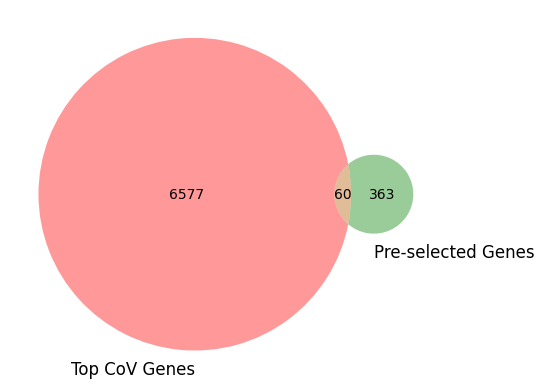

In [80]:

venn2([set(gene_df), set(regions_genes)], set_labels = ('Top CoV Genes', 'Pre-selected Genes'))
plt.show()

In [81]:
union_genes = np.union1d(gene_df, regions_genes)

len(union_genes)

7000

# Normalize data

In [82]:
X_full = X_full.loc[:,union_genes]

## normalize within sample
clip_upper = np.quantile(X_full, 0.9)
X_full = np.clip(X_full, 0, clip_upper)
scaler = MinMaxScaler()
scaler.fit(X_full)

# now normalize with the scaler trained on the 
# training data
X_full = np.clip(X_full, 0, clip_upper)
X_full = scaler.transform(X_full)


# for unknown proportions; 
# this is bulks used in training
X_unkp = X_full[idx_test,]
label_unkp = label_full[idx_test,]
bulk_unkp = bulk_full[idx_test,]
drug_unkp = drug_full[idx_test,]
y_unkp = Y_full.iloc[idx_test]
y_unkp = y_unkp.to_numpy()
meta_unkp = meta_df.iloc[idx_test]

# for known proportions
X_kp = X_full[idx_train,]
label_kp = label_full[idx_train,]
bulk_kp = bulk_full[idx_train,]
drug_kp = drug_full[idx_train,]
y_kp = Y_full.iloc[idx_train]
y_kp = y_kp.to_numpy()
meta_kp = meta_df.iloc[idx_train]


In [83]:
y_kp

array([[0.018     , 0.453     , 0.001     , ..., 0.001     , 0.001     ,
        0.366     ],
       [0.32      , 0.03      , 0.07      , ..., 0.02      , 0.01      ,
        0.01      ],
       [0.07293293, 0.08231231, 0.08294294, ..., 0.04238238, 0.08708709,
        0.0529029 ],
       ...,
       [0.06221053, 0.00189474, 0.02594737, ..., 0.10626316, 0.02263158,
        0.00094737],
       [0.0646    , 0.0286    , 0.0016    , ..., 0.0172    , 0.0994    ,
        0.1454    ],
       [0.019996  , 0.08438312, 0.11457708, ..., 0.03879224, 0.13297341,
        0.02819436]])

In [84]:
y_unkp

array([[0.00179964, 0.00879824, 0.07578484, ..., 0.04939012, 0.00219956,
        0.14057189],
       [0.00394737, 0.01352632, 0.06589474, ..., 0.02715789, 0.13015789,
        0.01173684],
       [0.02      , 0.01      , 0.5       , ..., 0.02      , 0.01      ,
        0.01      ],
       ...,
       [0.198     , 0.172     , 0.07      , ..., 0.13      , 0.028     ,
        0.134     ],
       [0.008     , 0.021     , 0.491     , ..., 0.035     , 0.053     ,
        0.002     ],
       [0.53409318, 0.0179964 , 0.07178564, ..., 0.02259548, 0.01759648,
        0.05018996]])

# Plot all data

In [85]:
meta_df

,sample_id,cancer_type,isTraining,num_blood,samp_type,Y_max
PRAD_C276D64C_147B_4F15_A27E_A8068FB06146_X025_S09_L043_B1_T1_P068,PRAD_C276D64C_147B_4F15_A27E_A8068FB06146_X025...,PRAD,Train,1000,1000,PRAD
LUSC_5AC6ED60_B4C0_42C1_BAB1_A173859818AE_X025_S04_L033_B1_T1_P061,LUSC_5AC6ED60_B4C0_42C1_BAB1_A173859818AE_X025...,LUNG,Train,100,100,LUNG
LIHC_39F9069F_8AA1_46EE_B127_69157C3A94A1_X035_S09_L017_B1_T1_P099,LIHC_39F9069F_8AA1_46EE_B127_69157C3A94A1_X035...,LIHC,Train,99900,99900,LIHC
COAD_DC7564C4_1BB1_4FC9_B8BB_B557E69E35CC_X013_S11_L068_B1_T1_P030,COAD_DC7564C4_1BB1_4FC9_B8BB_B557E69E35CC_X013...,COAD,Train,100,100,COAD
PRAD_BDFE10D1_4C84_446B_B962_20985B57AE5D_X033_S11_L114_B1_T1_P079,PRAD_BDFE10D1_4C84_446B_B962_20985B57AE5D_X033...,PRAD,Train,1000,1000,PRAD
...,...,...,...,...,...,...
STAD_BAB7D0D7_4F14_4ED4_B8E4_B9E760F57246_X041_S02_L003_B1_T1_P084,STAD_BAB7D0D7_4F14_4ED4_B8E4_B9E760F57246_X041...,STAD,heldout,99900,99900,STAD
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_S09_L065_B1_T1_PMRG,STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037...,STAD,heldout,99900,99900,STAD
STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037_S09_L066_B1_T2_P088,STAD_D1C43A87_4C70_4AE9_9023_880A46E79F21_X037...,STAD,heldout,99900,99900,STAD
STAD_E07AAE91_7A4F_4FDC_9D67_4FA1D4E6DD89_X024_S05_L012_B1_T2_P069,STAD_E07AAE91_7A4F_4FDC_9D67_4FA1D4E6DD89_X024...,STAD,heldout,99900,99900,STAD


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.014s...
[t-SNE] Computed neighbors for 10000 samples in 2.344s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.342077
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.444977
[t-SNE] KL divergence after 500 iterations: 1.115120
(10000, 2)
(10000, 2)


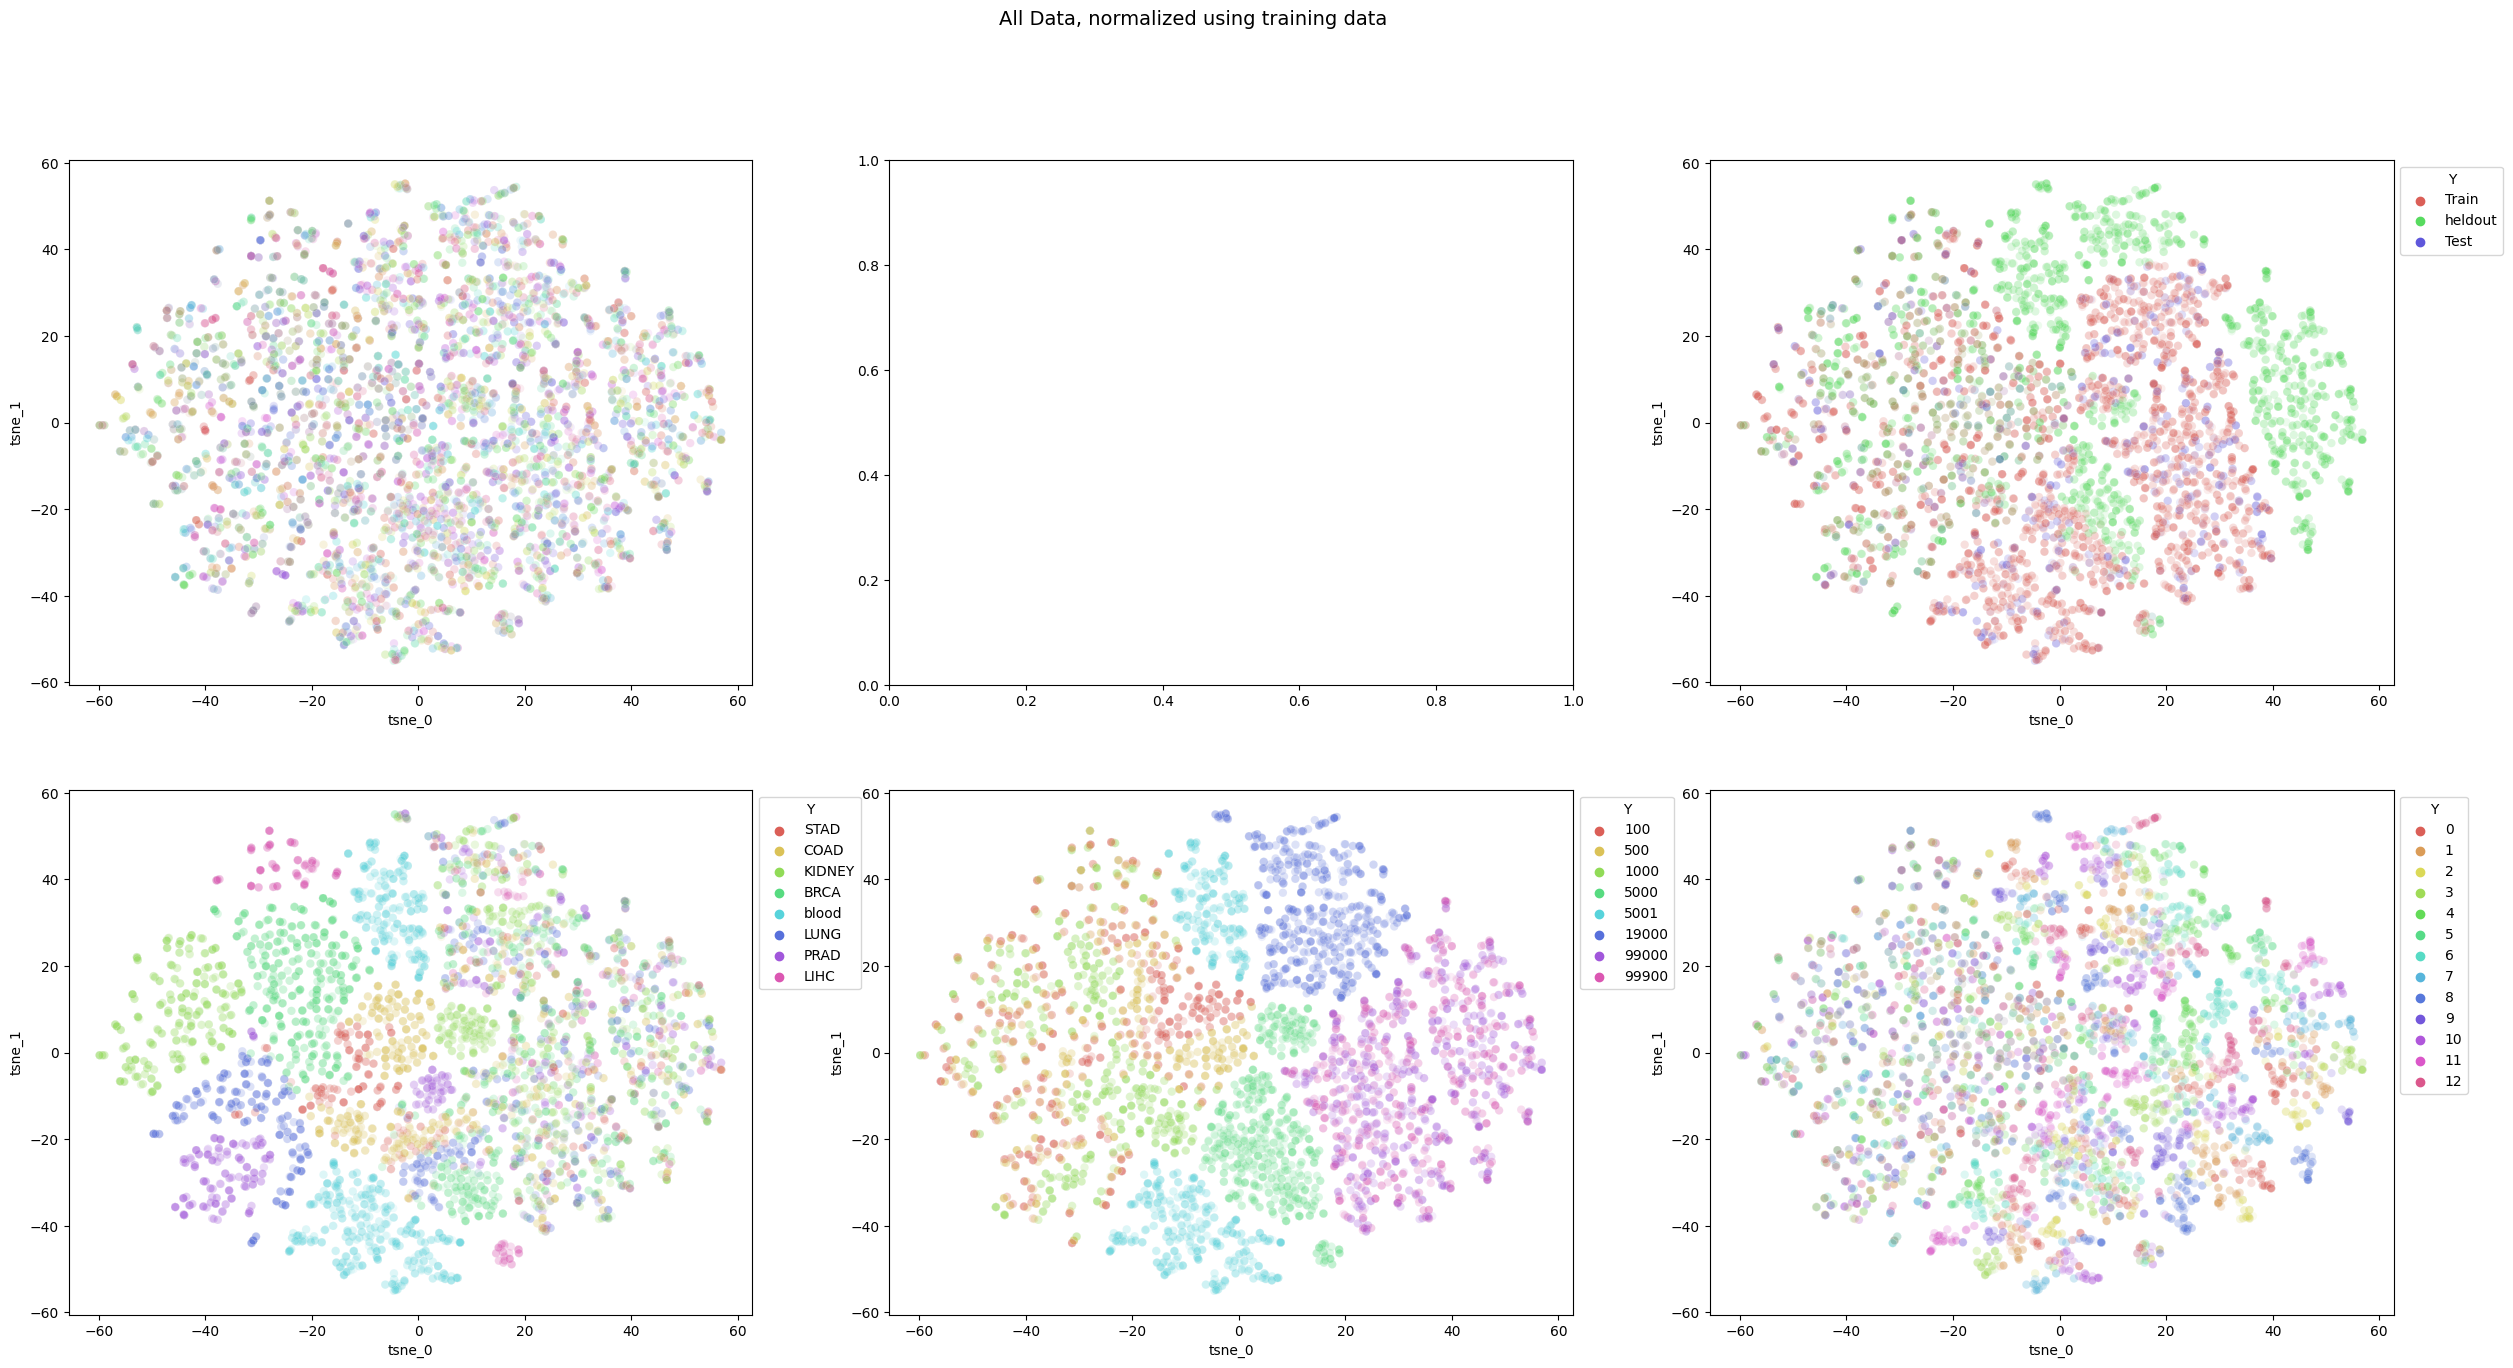

In [86]:
## plot samples
idx_tmp = np.random.choice(range(X_full.shape[0]), 10000, replace=True)


plot_df = vp.get_tsne_for_plotting(X_full[idx_tmp,])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_full.iloc[idx_tmp])
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].sample_id.to_numpy(), axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].isTraining.to_numpy(), axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].cancer_type.to_numpy(), axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_df.iloc[idx_tmp].num_blood.to_numpy(), axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


# **Run SVM**

## Hyperparameter Search

We are going to search over 2 parameters: 

1.  the weighting of the loss for the latent space classifications against the reconstruction (100, 1000, 10000)
2.  the number of epochs  (50, 100, 200)

In [87]:
y_kp

array([[0.018     , 0.453     , 0.001     , ..., 0.001     , 0.001     ,
        0.366     ],
       [0.32      , 0.03      , 0.07      , ..., 0.02      , 0.01      ,
        0.01      ],
       [0.07293293, 0.08231231, 0.08294294, ..., 0.04238238, 0.08708709,
        0.0529029 ],
       ...,
       [0.06221053, 0.00189474, 0.02594737, ..., 0.10626316, 0.02263158,
        0.00094737],
       [0.0646    , 0.0286    , 0.0016    , ..., 0.0172    , 0.0994    ,
        0.1454    ],
       [0.019996  , 0.08438312, 0.11457708, ..., 0.03879224, 0.13297341,
        0.02819436]])

# SVM run on all samples

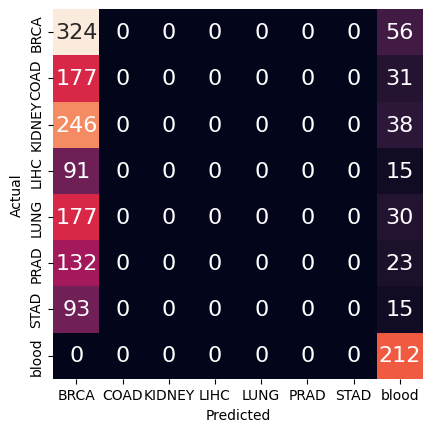

              precision    recall  f1-score   support

        BRCA       0.26      0.85      0.40       380
        COAD       0.00      0.00      0.00       208
      KIDNEY       0.00      0.00      0.00       284
        LIHC       0.00      0.00      0.00       106
        LUNG       0.00      0.00      0.00       207
        PRAD       0.00      0.00      0.00       155
        STAD       0.00      0.00      0.00       108
       blood       0.50      1.00      0.67       212

    accuracy                           0.32      1660
   macro avg       0.10      0.23      0.13      1660
weighted avg       0.12      0.32      0.18      1660



/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [117]:


train_100_idx = np.where(meta_kp.num_blood > 0)[0]
test_100_idx = np.where(np.logical_and(meta_df.isTraining == "heldout", meta_df.num_blood > 0))[0]

training_X = X_kp[train_100_idx]
training_y = drug_kp[train_100_idx]

testing_X = X_full[test_100_idx]
testing_y = drug_full[test_100_idx]

training_y = np.argmax(training_y, axis=1)
testing_y = np.argmax(testing_y, axis=1)


# predict the cancer type (drug here) from the peaks
clf = svm.SVC(decision_function_shape='ovo')

# fit
clf.fit(training_X, training_y)

# predict
pred_labels = clf.predict(testing_X)

# plot CM
ct_pred = pred_labels
ct_true = testing_y
labels = index_drug[[0, 1, 2, 3, 4, 5, 6, 7]]

cm = confusion_matrix(ct_true, ct_pred)

df_cm = pd.DataFrame(cm, labels, labels)
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 8) #this manually corrects the cutoff issue in sns.heatmap found in matplotlib ver 3.1.1
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
ax.invert_yaxis() #optional
plt.show()

# print report
print(classification_report(ct_true, ct_pred, target_names=labels))


# SVM high proportion cancer samples

number of blood samples used: 5000, 1000, 500, 100, 19000, 99000, 99900


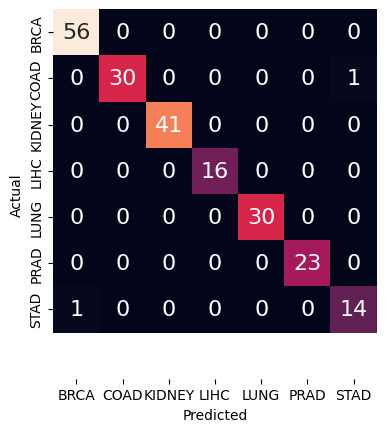

              precision    recall  f1-score   support

        BRCA       0.98      1.00      0.99        56
        COAD       1.00      0.97      0.98        31
      KIDNEY       1.00      1.00      1.00        41
        LIHC       1.00      1.00      1.00        16
        LUNG       1.00      1.00      1.00        30
        PRAD       1.00      1.00      1.00        23
        STAD       0.93      0.93      0.93        15

    accuracy                           0.99       212
   macro avg       0.99      0.99      0.99       212
weighted avg       0.99      0.99      0.99       212



In [115]:
train_100_idx = np.where(meta_kp.num_blood == 100)[0]
test_100_idx = np.where(np.logical_and(meta_df.isTraining == "heldout", meta_df.num_blood == 100))[0]

training_X = X_kp[train_100_idx]
training_y = drug_kp[train_100_idx]

testing_X = X_full[test_100_idx]
testing_y = drug_full[test_100_idx]

training_y = np.argmax(training_y, axis=1)
testing_y = np.argmax(testing_y, axis=1)


# predict the cancer type (drug here) from the peaks
clf = svm.SVC(decision_function_shape='ovo')

# fit
clf.fit(training_X, training_y)

# predict
pred_labels = clf.predict(testing_X)

# plot CM
ct_pred = pred_labels
ct_true = testing_y
labels = index_drug[[0, 1, 2, 3, 4, 5, 6]]

cm = confusion_matrix(ct_true, ct_pred)

df_cm = pd.DataFrame(cm, labels, labels)
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 8) #this manually corrects the cutoff issue in sns.heatmap found in matplotlib ver 3.1.1
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
ax.invert_yaxis() #optional
plt.show()

# print report
print(classification_report(ct_true, ct_pred, target_names=labels))


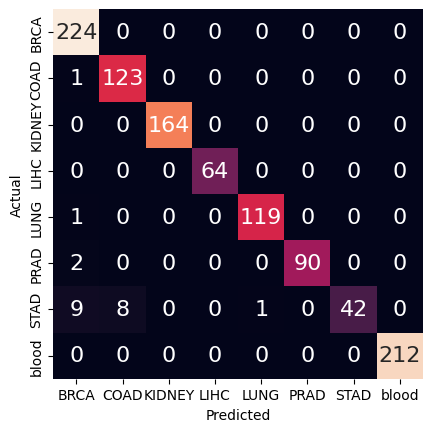

              precision    recall  f1-score   support

        BRCA       0.95      1.00      0.97       224
        COAD       0.94      0.99      0.96       124
      KIDNEY       1.00      1.00      1.00       164
        LIHC       1.00      1.00      1.00        64
        LUNG       0.99      0.99      0.99       120
        PRAD       1.00      0.98      0.99        92
        STAD       1.00      0.70      0.82        60
       blood       1.00      1.00      1.00       212

    accuracy                           0.98      1060
   macro avg       0.98      0.96      0.97      1060
weighted avg       0.98      0.98      0.98      1060



In [119]:
train_100_idx = np.where(meta_kp.num_blood < 19000)[0]
test_100_idx = np.where(np.logical_and(meta_df.isTraining == "heldout", meta_df.num_blood < 19000))[0]

training_X = X_kp[train_100_idx]
training_y = drug_kp[train_100_idx]

testing_X = X_full[test_100_idx]
testing_y = drug_full[test_100_idx]

training_y = np.argmax(training_y, axis=1)
testing_y = np.argmax(testing_y, axis=1)


# predict the cancer type (drug here) from the peaks
clf = svm.SVC(decision_function_shape='ovo')

# fit
clf.fit(training_X, training_y)

# predict
pred_labels = clf.predict(testing_X)

# plot CM
ct_pred = pred_labels
ct_true = testing_y
labels = index_drug[[0, 1, 2, 3, 4, 5, 6, 7]]

cm = confusion_matrix(ct_true, ct_pred)

df_cm = pd.DataFrame(cm, labels, labels)
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 8) #this manually corrects the cutoff issue in sns.heatmap found in matplotlib ver 3.1.1
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
ax.invert_yaxis() #optional
plt.show()

# print report
print(classification_report(ct_true, ct_pred, target_names=labels))


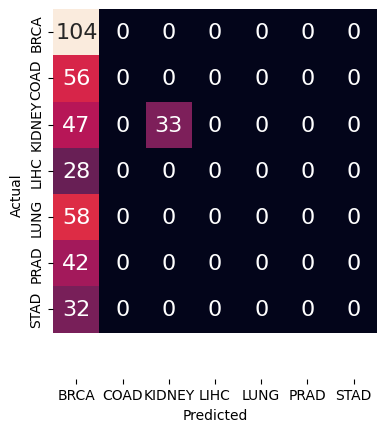

              precision    recall  f1-score   support

        BRCA       0.28      1.00      0.44       104
        COAD       0.00      0.00      0.00        56
      KIDNEY       1.00      0.41      0.58        80
        LIHC       0.00      0.00      0.00        28
        LUNG       0.00      0.00      0.00        58
        PRAD       0.00      0.00      0.00        42
        STAD       0.00      0.00      0.00        32

    accuracy                           0.34       400
   macro avg       0.18      0.20      0.15       400
weighted avg       0.27      0.34      0.23       400



/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [121]:
train_100_idx = np.where(meta_kp.num_blood > 19000)[0]
test_100_idx = np.where(np.logical_and(meta_df.isTraining == "heldout", meta_df.num_blood > 19000))[0]

training_X = X_kp[train_100_idx]
training_y = drug_kp[train_100_idx]

testing_X = X_full[test_100_idx]
testing_y = drug_full[test_100_idx]

training_y = np.argmax(training_y, axis=1)
testing_y = np.argmax(testing_y, axis=1)


# predict the cancer type (drug here) from the peaks
clf = svm.SVC(decision_function_shape='ovo')

# fit
clf.fit(training_X, training_y)

# predict
pred_labels = clf.predict(testing_X)

# plot CM
ct_pred = pred_labels
ct_true = testing_y
labels = index_drug[[0, 1, 2, 3, 4, 5, 6]]

cm = confusion_matrix(ct_true, ct_pred)

df_cm = pd.DataFrame(cm, labels, labels)
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 8) #this manually corrects the cutoff issue in sns.heatmap found in matplotlib ver 3.1.1
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
ax.invert_yaxis() #optional
plt.show()

# print report
print(classification_report(ct_true, ct_pred, target_names=labels))


# run analysis on AdaBoost 

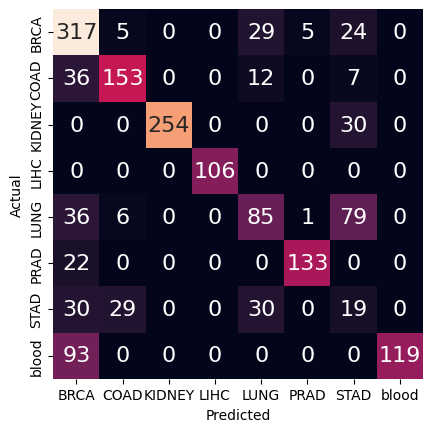

              precision    recall  f1-score   support

        BRCA       0.59      0.83      0.69       380
        COAD       0.79      0.74      0.76       208
      KIDNEY       1.00      0.89      0.94       284
        LIHC       1.00      1.00      1.00       106
        LUNG       0.54      0.41      0.47       207
        PRAD       0.96      0.86      0.90       155
        STAD       0.12      0.18      0.14       108
       blood       1.00      0.56      0.72       212

    accuracy                           0.71      1660
   macro avg       0.75      0.68      0.70      1660
weighted avg       0.76      0.71      0.72      1660



In [126]:


train_100_idx = np.where(meta_kp.num_blood > 0)[0]
test_100_idx = np.where(np.logical_and(meta_df.isTraining == "heldout", meta_df.num_blood > 0))[0]

training_X = X_kp[train_100_idx]
training_y = drug_kp[train_100_idx]

testing_X = X_full[test_100_idx]
testing_y = drug_full[test_100_idx]

training_y = np.argmax(training_y, axis=1)
testing_y = np.argmax(testing_y, axis=1)


# predict the cancer type (drug here) from the peaks
clf = AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=0)

# fit
clf.fit(training_X, training_y)

# predict
pred_labels = clf.predict(testing_X)

# plot CM
ct_pred = pred_labels
ct_true = testing_y
labels = index_drug[[0, 1, 2, 3, 4, 5, 6, 7]]

cm = confusion_matrix(ct_true, ct_pred)

df_cm = pd.DataFrame(cm, labels, labels)
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 8) #this manually corrects the cutoff issue in sns.heatmap found in matplotlib ver 3.1.1
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
ax.invert_yaxis() #optional
plt.show()

# print report
print(classification_report(ct_true, ct_pred, target_names=labels))


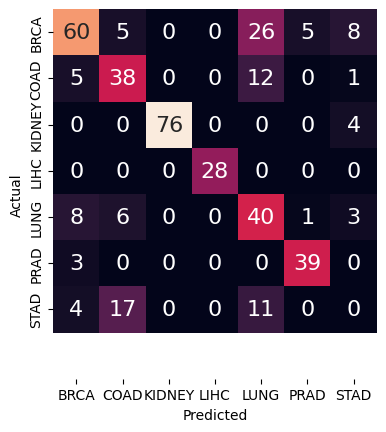

              precision    recall  f1-score   support

        BRCA       0.75      0.58      0.65       104
        COAD       0.58      0.68      0.62        56
      KIDNEY       1.00      0.95      0.97        80
        LIHC       1.00      1.00      1.00        28
        LUNG       0.45      0.69      0.54        58
        PRAD       0.87      0.93      0.90        42
        STAD       0.00      0.00      0.00        32

    accuracy                           0.70       400
   macro avg       0.66      0.69      0.67       400
weighted avg       0.70      0.70      0.69       400



In [133]:

train_100_idx = np.where(meta_kp.num_blood > 0)[0]
test_100_idx = np.where(np.logical_and(meta_df.isTraining == "heldout", meta_df.num_blood > 19000))[0]

training_X = X_kp[train_100_idx]
training_y = drug_kp[train_100_idx]

testing_X = X_full[test_100_idx]
testing_y = drug_full[test_100_idx]

training_y = np.argmax(training_y, axis=1)
testing_y = np.argmax(testing_y, axis=1)


# predict the cancer type (drug here) from the peaks
clf = AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=0)

# fit
clf.fit(training_X, training_y)

# predict
pred_labels = clf.predict(testing_X)

# plot CM
ct_pred = pred_labels
ct_true = testing_y
labels = index_drug[[0, 1, 2, 3, 4, 5, 6]]

cm = confusion_matrix(ct_true, ct_pred)

df_cm = pd.DataFrame(cm, labels, labels)
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 8) #this manually corrects the cutoff issue in sns.heatmap found in matplotlib ver 3.1.1
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
ax.invert_yaxis() #optional
plt.show()

# print report
print(classification_report(ct_true, ct_pred, target_names=labels))


# Predict using MLP

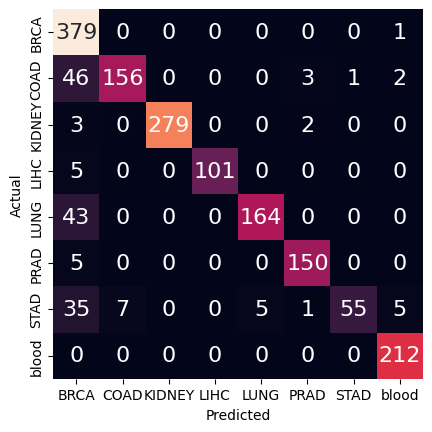

              precision    recall  f1-score   support

        BRCA       0.73      1.00      0.85       380
        COAD       0.96      0.75      0.84       208
      KIDNEY       1.00      0.98      0.99       284
        LIHC       1.00      0.95      0.98       106
        LUNG       0.97      0.79      0.87       207
        PRAD       0.96      0.97      0.96       155
        STAD       0.98      0.51      0.67       108
       blood       0.96      1.00      0.98       212

    accuracy                           0.90      1660
   macro avg       0.95      0.87      0.89      1660
weighted avg       0.92      0.90      0.90      1660



In [129]:

train_100_idx = np.where(meta_kp.num_blood > 0)[0]
test_100_idx = np.where(np.logical_and(meta_df.isTraining == "heldout", meta_df.num_blood > 0))[0]

training_X = X_kp[train_100_idx]
training_y = drug_kp[train_100_idx]

testing_X = X_full[test_100_idx]
testing_y = drug_full[test_100_idx]

training_y = np.argmax(training_y, axis=1)
testing_y = np.argmax(testing_y, axis=1)


# predict the cancer type (drug here) from the peaks
clf = MLPClassifier(random_state=1, max_iter=300)

# fit
clf.fit(training_X, training_y)

# predict
pred_labels = clf.predict(testing_X)

# plot CM
ct_pred = pred_labels
ct_true = testing_y
labels = index_drug[[0, 1, 2, 3, 4, 5, 6, 7]]

cm = confusion_matrix(ct_true, ct_pred)

df_cm = pd.DataFrame(cm, labels, labels)
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 8) #this manually corrects the cutoff issue in sns.heatmap found in matplotlib ver 3.1.1
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
ax.invert_yaxis() #optional
plt.show()

# print report
print(classification_report(ct_true, ct_pred, target_names=labels))


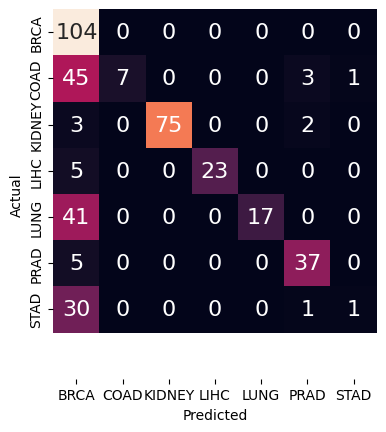

              precision    recall  f1-score   support

        BRCA       0.45      1.00      0.62       104
        COAD       1.00      0.12      0.22        56
      KIDNEY       1.00      0.94      0.97        80
        LIHC       1.00      0.82      0.90        28
        LUNG       1.00      0.29      0.45        58
        PRAD       0.86      0.88      0.87        42
        STAD       0.50      0.03      0.06        32

    accuracy                           0.66       400
   macro avg       0.83      0.58      0.58       400
weighted avg       0.80      0.66      0.61       400



In [131]:

train_100_idx = np.where(meta_kp.num_blood > 0)[0]
test_100_idx = np.where(np.logical_and(meta_df.isTraining == "heldout", meta_df.num_blood > 19000))[0]

training_X = X_kp[train_100_idx]
training_y = drug_kp[train_100_idx]

testing_X = X_full[test_100_idx]
testing_y = drug_full[test_100_idx]

training_y = np.argmax(training_y, axis=1)
testing_y = np.argmax(testing_y, axis=1)


# predict the cancer type (drug here) from the peaks
clf = MLPClassifier(random_state=1, max_iter=300)

# fit
clf.fit(training_X, training_y)

# predict
pred_labels = clf.predict(testing_X)

# plot CM
ct_pred = pred_labels
ct_true = testing_y
labels = index_drug[[0, 1, 2, 3, 4, 5, 6]]

cm = confusion_matrix(ct_true, ct_pred)

df_cm = pd.DataFrame(cm, labels, labels)
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, square=True, cbar=False, fmt='g')
ax.set_ylim(0, 8) #this manually corrects the cutoff issue in sns.heatmap found in matplotlib ver 3.1.1
plt.xlabel("Predicted") 
plt.ylabel("Actual") 
ax.invert_yaxis() #optional
plt.show()

# print report
print(classification_report(ct_true, ct_pred, target_names=labels))
